In [102]:
from google_cloud import BigQuery, Storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import os
import sys

import boto3
import base64

In [6]:
#Cliente BigQuery
AUTH_BIGQUERY = base64.b64decode(os.environ['SECRET_AUTH_BIGQUERY_MODEL'])
bq = BigQuery(AUTH_BIGQUERY)
storage =Storage(AUTH_BIGQUERY)

In [ ]:
#GAIA:
#JOBS: HYPER - V_BT_PUSH_COUPON_CAMPAIGN_EVENT (genera el extracto para el dash)
#      PUSH - BT_PUSH_ML_BATCH_COUPON_CAMPAIGN_EVENT

# meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT
# "BATCH_ID": "MLB_MP_PUSHMP_AO_P_ALL_RECU_SELL_TRANSFERENCIA-DEVICE_DEFAULT",
# "CAMPAIGN_ID": "MLB_MP_PUSHMP_AO_P_ALL_RECU_SELL_TRANSFERENCIA-DEVICE",
# "CAMPAIGN_TYPE": "recurrente_mp",
# "SENT_DATE": "2021-02-11",
# "APP": "mercadopago",
# "SIT_SITE_ID": "MLB",
# "TIM_DAY": "2021-02-11",
# "CUS_CUST_ID": "186910412",
# "EVENT_TYPE": "arrived",
# "DEVICE_PLATFORM": "/mobile/ios",
# "ADVERTISER_ID": "EC3F9C41-01FE-4E58-8A70-B28FE7C658F4"

#EVENT_TYPE: {holdre,holdad,sent,shown,open,control,blacklist,discarded,arrived}
#SENT_DATE: {min:2022-01-05, max:2022-02-22}

#Measures (tableau).
#Exposure: SHOW/SENT
#Open Rate: OPEN/SHOWN (check con Pedro, valores no cuadran con el dash)

In [78]:
%%time
send_push_groups = bq.execute_response("""
SELECT push.EVENT_TYPE,push.SENT_DATE, count(distinct push.CUS_CUST_ID)
FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT push 
WHERE BATCH_ID LIKE 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%' 
    AND push.APP = 'mercadolibre' 
    AND push.sit_site_id = 'MLB' 
    AND push.SENT_DATE >= DATE '2022-01-01'
GROUP BY 1,2
""")

CPU times: user 60.1 ms, sys: 3.55 ms, total: 63.6 ms
Wall time: 944 ms


/usr/local/lib/python3.7/site-packages/google/cloud/bigquery/client.py:445: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [79]:
send_push_groups['SENT_DATE'] = pd.to_datetime(send_push_groups.SENT_DATE)

send_push_groups_pivot = send_push_groups.pivot_table(index = 'SENT_DATE', values = 'f0_',columns = 'EVENT_TYPE').reset_index()
send_push_groups_pivot['open_rate'] = send_push_groups_pivot.open/(send_push_groups_pivot.shown)
send_push_groups_pivot['exposure'] = send_push_groups_pivot.shown/(send_push_groups_pivot.sent)

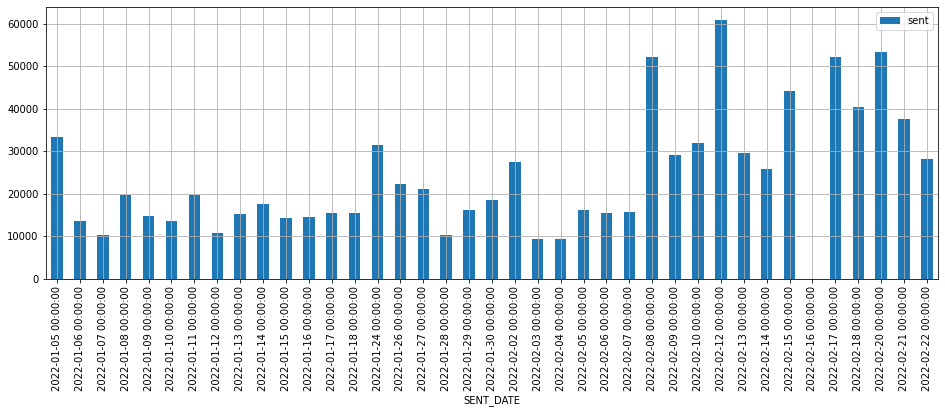

In [101]:
#SEND
send_push_groups_pivot.plot.bar(x = 'SENT_DATE',y = 'sent', figsize = (16,5))
plt.grid()

In [120]:
send_push_groups_pivot['weekday'] = send_push_groups_pivot.SENT_DATE.dt.weekday

<AxesSubplot:title={'center':'sent'}, xlabel='weekday'>

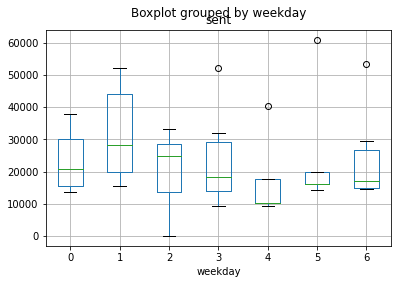

In [125]:
#HAy variaciones en la cantidad de push enviadas por dia de la semana?
send_push_groups_pivot.boxplot(column = 'sent',by = 'weekday')
#0: Lunes
#6: domingo

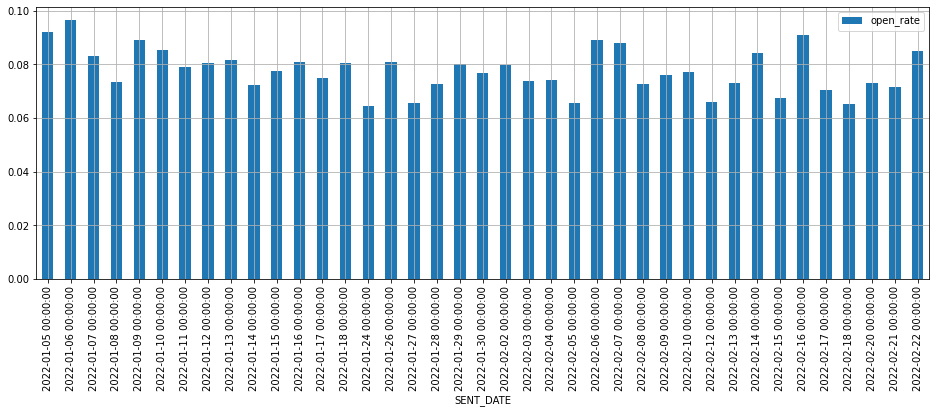

In [100]:
#OPEN RATE
send_push_groups_pivot.plot.bar(x = 'SENT_DATE',y = 'open_rate', figsize = (16,5))
plt.grid()
#Parece uniforme el open rate 

<AxesSubplot:title={'center':'open_rate'}, xlabel='weekday'>

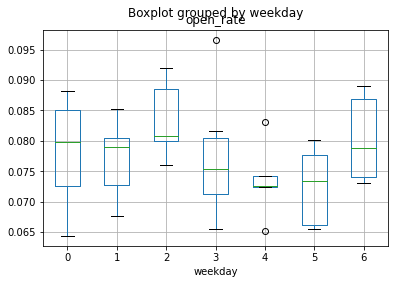

In [126]:
#Se diferencia el open rate por dia de la semana?
send_push_groups_pivot.boxplot(column = 'open_rate',by = 'weekday')

In [130]:
send_push_groups_pivot.groupby('weekday').sent.sum().sum()

926985.0

In [132]:
#Cantidades nominales
(send_push_groups_pivot.groupby('weekday').sent.sum()*100)/send_push_groups_pivot.groupby('weekday').sent.sum().sum()

weekday
0    15.061625
1    17.225090
2    13.247248
3    15.458718
4     9.479873
5    13.746501
6    15.780946
Name: sent, dtype: float64

In [221]:
# CONVERSION
site = 'MLB'
date_intial = '2022-01-01'
date_end = '2022-01-07'
conversion_query = \
f"""
    WITH push as ( 
        SELECT push.CUS_CUST_ID,push.sit_site_id, push.SENT_DATE, push.EVENT_TYPE 
        FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT push 
        WHERE BATCH_ID LIKE 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%' 
        AND push.EVENT_TYPE in ('sent','control') 
        AND push.APP = 'mercadolibre'
        AND push.sit_site_id = '{site}' 
        AND push.SENT_DATE BETWEEN DATE '{date_intial}' AND DATE '{date_end}' 
         ),
    orders as (
    SELECT push.CUS_CUST_ID, 
    push.SENT_DATE, 
    push.EVENT_TYPE,
    orders.ORD_CREATED_DT,
    ROW_NUMBER() OVER (PARTITION BY push.CUS_CUST_ID ORDER BY orders.ORD_CREATED_DT) AS ORDERING_PURCHASE
    FROM push LEFT JOIN meli-bi-data.WHOWNER.BT_ORD_ORDERS orders
    ON push.CUS_CUST_ID = orders.ORD_BUYER.ID 
        AND push.sit_site_id = orders.SIT_SITE_ID 
        AND ORD_CLOSED_DT is not null
        AND orders.ord_status = 'paid' 
        AND orders.ORD_CLOSED_DT BETWEEN push.SENT_DATE AND DATE_ADD(push.SENT_DATE, INTERVAL 4 DAY) 
        AND orders.ORD_CREATED_DT = push.SENT_DATE
    )
    
    SELECT * EXCEPT(ORDERING_PURCHASE), CASE WHEN ORD_CREATED_DT is null THEN 0 ELSE 1 END AS CONVERSION
    FROM orders WHERE ORDERING_PURCHASE = 1
""" 
conversion  = " ".join(conversion_query.split()) 
conversion

"WITH push as ( SELECT push.CUS_CUST_ID,push.sit_site_id, push.SENT_DATE, push.EVENT_TYPE FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT push WHERE BATCH_ID LIKE 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%' AND push.EVENT_TYPE in ('sent','control') AND push.APP = 'mercadolibre' AND push.sit_site_id = 'MLB' AND push.SENT_DATE BETWEEN DATE '2022-01-01' AND DATE '2022-01-07' ), orders as ( SELECT push.CUS_CUST_ID, push.SENT_DATE, push.EVENT_TYPE, orders.ORD_CREATED_DT, ROW_NUMBER() OVER (PARTITION BY push.CUS_CUST_ID ORDER BY orders.ORD_CREATED_DT) AS ORDERING_PURCHASE FROM push LEFT JOIN meli-bi-data.WHOWNER.BT_ORD_ORDERS orders ON push.CUS_CUST_ID = orders.ORD_BUYER.ID AND push.sit_site_id = orders.SIT_SITE_ID AND ORD_CLOSED_DT is not null AND orders.ord_status = 'paid' AND orders.ORD_CLOSED_DT BETWEEN push.SENT_DATE AND DATE_ADD(push.SENT_DATE, INTERVAL 4 DAY) AND orders.ORD_CREATED_DT = push.SENT_DATE ) SELECT * EXCEPT(ORDERING_PURCHASE), CASE WHEN ORD_CREATED_DT is null TH

In [222]:
%%time
conversion_df = bq.execute_response(conversion)

/usr/local/lib/python3.7/site-packages/google/cloud/bigquery/client.py:445: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


CPU times: user 1.86 s, sys: 120 ms, total: 1.98 s
Wall time: 41.7 s


In [218]:
conversion_df.head()

,CUS_CUST_ID,SENT_DATE,EVENT_TYPE,ORD_CREATED_DT,ORD_TOTAL_AMOUNT,ORD_PAID_AMOUNT,ITE_ITEM_ID,CONVERSION
0,218133825,2022-01-07,sent,None,None,None,NaN,0
1,232872429,2022-01-07,sent,None,None,None,NaN,0
2,308568480,2022-01-06,sent,None,None,None,NaN,0
3,330637954,2022-01-05,sent,None,None,None,NaN,0
4,397062150,2022-01-05,sent,None,None,None,NaN,0


In [223]:
np.round(conversion_df.groupby(['SENT_DATE','EVENT_TYPE']).CONVERSION.mean()*100,3)

SENT_DATE   EVENT_TYPE
2022-01-05  control       1.919
            sent          2.075
2022-01-06  control       2.867
            sent          2.500
2022-01-07  control       1.070
            sent          2.229
Name: CONVERSION, dtype: float64

In [ ]:
# CONVERSION
site = 'MLB'
date_intial = '2022-01-01'
date_end = '2022-01-07'
last_push_query = \
f"""
    SELECT push.CUS_CUST_ID,push.sit_site_id, push.SENT_DATE, push.EVENT_TYPE 
    FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT push 
    WHERE BATCH_ID LIKE 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%' 
    AND push.EVENT_TYPE in ('sent','control') 
    AND push.APP = 'mercadolibre'
    AND push.sit_site_id = '{site}' 
    AND push.SENT_DATE BETWEEN DATE '{date_intial}' - 7 AND DATE '{date_intial}' -1 
         
""" 
conversion  = " ".join(conversion_query.split()) 
conversion

In [ ]:
WITH SENTS AS(
    select b.cus_cust_id,b.sit_site_id,SENT_DATE,EVENT_TYPE
    from meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT b
    where BATCH_ID like 'MLB_ML_PUSHML_AO_ALL_X_ACT_ALL_NEWBUYERS%'
        and b.EVENT_TYPE in ('sent','control')
        and APP = 'mercadolibre'
        and sit_site_id = 'MLB'
        AND b.SENT_DATE between DATE'2022-02-12' AND DATE'2022-02-14'
    group by 1,2,3,4
    )
    select  s.cus_cust_id,EVENT_TYPE, sent_date,
            buy_proba,
        MAX(CASE WHEN ords.ORD_BUYER.ID is not null THEN 1 ELSE 0 END) as buy
    from  SENTS s
    left join meli-marketing.MODELLING.NB_PREDICT_PROBA nb
        on nb.cus_cust_id = s.cus_cust_id
        AND nb.process_date = s.sent_date
        AND nb.sit_site_id = s.sit_site_id
    left join meli-bi-data.WHOWNER.BT_ORD_ORDERS ords
        on s.sit_site_id = ords.sit_site_id
        and s.cus_cust_id = ords.ORD_BUYER.ID
        AND ORD_STATUS = 'paid' and ORD_CLOSED_DT is not null
        AND ORD_CLOSED_DT between sent_date AND sent_date+4
        AND ORD_CREATED_DT = sent_date
    group by 1,2,3,4

In [ ]:
#Pagos con descuento.
WITH TOOLS as(
SELECT  CAST(MKT_TOOL_ID as INT64) as CAMPAIGN_ID, sit_site_id
           FROM `meli-marketing.PUSH.LK_PUSH_BUDGET_COUPON` cp
           WHERE cp.sit_site_id in ('MLB')
        GROUP BY 1,2
)
  SELECT  SUM(cpn.mkt_cpn_amount) as descuento_lc
  FROM  `meli-bi-data.WHOWNER.BT_PAY_PAYMENTS` as pay
  INNER JOIN `meli-bi-data.WHOWNER.BT_MKT_COUPON_V2` as cpn
      on pay.pay_payment_id = cpn.pay_payment_id
      and pay.cus_cust_id_buy = cpn.cus_cust_id_buy
  INNER JOIN TOOLS t
    ON t.CAMPAIGN_ID = mkt_cpn_campaign_id
    AND pay.SIT_SITE_ID = t.SIT_SITE_ID
  WHERE
      pay.pay_status_code = 'approved'
      AND pay.SIT_SITE_ID in ('MLB')
      AND pay.pay_created_dt = date'2022-02-14'

In [ ]:
#Tabla de push.
#Comparar con converson.

In [37]:
new_buyer = pd.concat(new_buyer_list)
new_buyer['CUS_RU_SINCE'] = pd.to_datetime(new_buyer.CUS_RU_SINCE)

In [22]:
# %%time
# new_buyer = bq.execute_response(new_buyer_query)
# new_buyer['CUS_RU_SINCE'] = pd.to_datetime(new_buyer.CUS_RU_SINCE)

CPU times: user 1min 1s, sys: 4.94 s, total: 1min 6s
Wall time: 2min 5s


In [38]:
new_buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752177 entries, 0 to 2752176
Data columns (total 3 columns):
 #   Column        Dtype         
---  ------        -----         
 0   CUS_CUST_ID   int64         
 1   SIT_SITE_ID   object        
 2   CUS_RU_SINCE  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 63.0+ MB


<AxesSubplot:xlabel='CUS_RU_SINCE'>

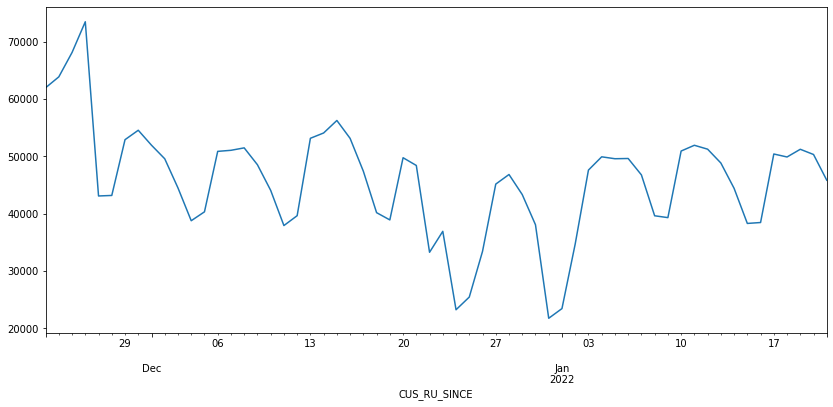

In [39]:
new_buyer.groupby('CUS_RU_SINCE').CUS_CUST_ID.count().plot.line(figsize = (14,6))